# Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [conclusions](#conclusions)


<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  
our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [2]:
#just to be beautiful 
class bt:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   bold = '\033[1m'
   UNDERLINE = '\033[4m'
   end = '\033[0m'

print(bt.bold + 'Hello World !' + bt.end)

#source https://stackoverflow.com/questions/8924173/how-do-i-print-bold-text-in-python ##

Hello World !


`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [3]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


* Use the below cell to find the number of rows in the dataset.
* The number of unique users in the dataset.
* The proportion of users converted.
* The number of times the `new_page` and `treatment` don't line up.
* Do any of the rows have missing values?

In [4]:
print( 
    
'Number of Row in the data set is:'
    , bt.bold ,df.shape[0],bt.end,
'\nNumber of unique users in the dataset is:'
    , bt.bold ,df.user_id.nunique(),bt.end,
'\nThe proportion of users converted in the dataset is:'
    , bt.bold ,round((df.groupby(['converted']).nunique().user_id[1]/df.user_id.nunique()* 100),2) , "%",bt.end,
"\nThe number of times the new_page and treatment don't line up is:",
    bt.bold ,df.query('group == "control" & landing_page == "new_page"').count()[0]+\
    df.query('group == "treatment" & landing_page == "old_page"').count()[0], bt.end,
"\nlist of columns with missing Values",
    bt.bold ,list(df.columns[df.isnull().any()]) ,  bt.end,
)

Number of Row in the data set is:  294478  
Number of unique users in the dataset is:  290584  
The proportion of users converted in the dataset is:  12.1 %  
The number of times the new_page and treatment don't line up is:  3893  
list of columns with missing Values  [] 


In [5]:
df.groupby(['group', 'landing_page']).count()

user_id  timestamp  converted
group     landing_page                               
control   new_page         1928       1928       1928
          old_page       145274     145274     145274
treatment new_page       145311     145311     145311
          old_page         1965       1965       1965

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [6]:
df2 = df.query('group == "control" & landing_page == "old_page"').append(df.query('group == "treatment" & landing_page == "new_page"'))
df2.tail(10)

,user_id,timestamp,group,landing_page,converted
294455,733101,2017-01-23 12:52:58.711914,treatment,new_page,0
294456,679096,2017-01-02 16:43:49.237940,treatment,new_page,0
294457,691699,2017-01-09 23:42:35.963486,treatment,new_page,0
294458,807595,2017-01-22 10:43:09.285426,treatment,new_page,0
294460,846225,2017-01-16 15:24:46.705903,treatment,new_page,0
294462,677163,2017-01-03 19:41:51.902148,treatment,new_page,0
294465,925675,2017-01-07 20:38:26.346410,treatment,new_page,0
294468,643562,2017-01-02 19:20:05.460595,treatment,new_page,0
294472,822004,2017-01-04 03:36:46.071379,treatment,new_page,0
294477,715931,2017-01-16 12:40:24.467417,treatment,new_page,0


In [7]:
df2.shape

(290585, 5)

In [8]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

* How many unique **user_id**s are in **df2**?
* There is one **user_id** repeated in **df2**.  What is it?
* What is the row information for the repeat **user_id**? 
* Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.


In [9]:
print('Number of unique users in the dataset is:'
      ,bt.bold ,df2.user_id.nunique(),bt.end,
     '\nThe repeated user id is:',
     bt.bold ,(df2[df2.duplicated('user_id')]['user_id'].tolist())[0],bt.end,
      '\nThe row information for the repeat user_id',
      '\n',bt.bold ,df2[df2.user_id == (df2[df2.duplicated('user_id')]['user_id'].tolist())[0]]
     )


Number of unique users in the dataset is:  290584  
The repeated user id is:  773192  
The row information for the repeat user_id 
        user_id                   timestamp      group landing_page  converted
1899   773192  2017-01-09 05:37:58.781806  treatment     new_page          0
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0


In [10]:
#Remove one of the rows with a duplicate user_id, but keep your dataframe as df2.
df2.drop(2893, inplace=True)
#check 
print('number of duplicated rows is',bt.bold , sum(df.duplicated()) , bt.end)

number of duplicated rows is  0 


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

b. Given that an individual was in the `control` group, what is the probability they converted?

c. Given that an individual was in the `treatment` group, what is the probability they converted?

d. What is the probability that an individual received the new page?

In [11]:
print('The probability of an individual converting regardless of the page they receive is:',
      bt.bold, round((df2.converted.mean()),4), bt.end,
                  
      '\nGiven that an individual was in the control group, the probability they converted is:',
       bt.bold, round((df2[df2.group == 'control'].converted.mean()),4), bt.end,
      
      '\nGiven that an individual was in the treatment group, the probability they converted is:',
       bt.bold, round((df2[df2.group == 'treatment'].converted.mean()),4),  bt.end,
      
      '\nThe probability that an individual received the new page is:',
      bt.bold, round(((df2['landing_page'] == "new_page").mean()),4), bt.end,
     )


The probability of an individual converting regardless of the page they receive is:  0.1196  
Given that an individual was in the control group, the probability they converted is:  0.1204  
Given that an individual was in the treatment group, the probability they converted is:  0.1188  
The probability that an individual received the new page is:  0.5001 


e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

The results in the previous two probabilities are too **close** and there is **no evidence** that one page will lead to more conversions.

we have to move on to A/B test 

<a id='ab_test'></a>
## Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$
H_0 : p_{new} - p_{old} \leq 0 \\
H_1 : p_{new} - p_{old} > 0 $$
Where $p_{new}$ & $p_{old}$ are the population mean values for new_page and old_page, respectivley.


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

* What is the **convert rate** for $p_{new}$ under the null? 
* What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [12]:
p_old = p_new = (df2.converted.mean())
print( 'the convert rate for  𝑝_𝑛𝑒𝑤  under the null = the convert rate for  𝑝𝑜𝑙𝑑  under the null is'
  ,bt.bold ,round(p_new,4), bt.end,
      '\ngiven that we are looking at a null where there is no difference in conversion based on the page'
)

the convert rate for  𝑝_𝑛𝑒𝑤  under the null = the convert rate for  𝑝𝑜𝑙𝑑  under the null is  0.1196  
given that we are looking at a null where there is no difference in conversion based on the page


c. What is $n_{new}$?

d. What is $n_{old}$?

In [13]:
n_new = df2[df2.landing_page == 'new_page'].shape[0]
n_old = df2[df2.landing_page == 'old_page'].shape[0]
print( '𝑛_𝑛𝑒𝑤 is:'
      ,bt.bold ,n_new, bt.end,
'\n𝑛_old is:'
      ,bt.bold ,n_old, bt.end,
)


𝑛_𝑛𝑒𝑤 is:  145310  
𝑛_old is:  145274 


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).


In [14]:
new_page_converted = np.random.choice([1,0], size=n_new ,p=[p_new,1 - p_new])
old_page_converted = np.random.choice([1,0], size=n_old ,p=[p_old,1 - p_old])
new_page_converted.mean() - old_page_converted.mean() 

0.0023654827110547727

In [15]:
new_page_converted.mean()

0.1210240176175074

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.





In [16]:
p_diffs , new_page_mean, old_page_mean = [] ,[] ,[] 

for i in range(10000):
    new_page = np.random.choice([1,0], size=n_new ,p=[p_new,1 - p_new])
    old_page = np.random.choice([1,0], size=n_old ,p=[p_old,1 - p_old])
    new_page_mean.append(new_page.mean())
    new_page_mean.append(old_page.mean())
    p_diffs.append(new_page.mean() - old_page.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

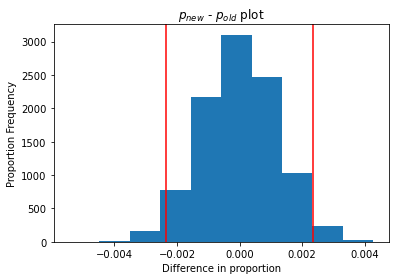

In [17]:
plt.hist(p_diffs);
lower, upper = np.percentile(p_diffs, 2.5), np.percentile(p_diffs, 97.5) 

plt.axvline(x=lower, color = "red");
plt.axvline(x=upper, color = "red");
plt.ylabel('Proportion Frequency');
plt.xlabel('Difference in proportion');
plt.title('$p_{new}$ - $p_{old}$ plot');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

proportion of the p_diffs are greater than the actual difference observed in ab_data.csv  0.9087 


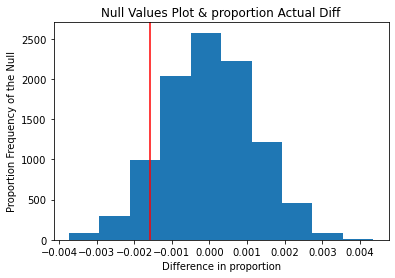

In [18]:
actual_diff = df2.query('landing_page == "new_page"').converted.mean() - df2.query('landing_page == "old_page"').converted.mean()
p_diffs = np.array(p_diffs)
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

print( 'proportion of the p_diffs are greater than the actual difference observed in ab_data.csv',
      bt.bold,  (null_vals > actual_diff).mean()  ,bt.end
)

plt.hist(null_vals);
plt.axvline(actual_diff, color = "red");
plt.ylabel('Proportion Frequency of the Null',);
plt.xlabel('Difference in proportion');
plt.title('Null Values Plot & proportion Actual Diff');

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

The **proprtion** where we have **p_diffs** ($p_{new} - p_{old} \leq 0$) greater than the **actual difference** in the population is the **p-value**. 

The **p-value** found was **large**( **90 %** )which suggest that we **don't** have evidence to **reject the null hypothesis**.

and that so There is **no** **sufficient** **evidence** to say that there is **convertion difference** between the new and old pages.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [19]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" & converted == "1"').count()[0]
convert_new = df2.query('landing_page == "new_page" & converted == "1"').count()[0]
n_old = df2.query('landing_page == "old_page"').count()[0]
n_new = df2.query('landing_page == "new_page"').count()[0]
print(
    'converted old', bt.bold, convert_old, bt.end,
    '\nconverted new' , bt.bold, convert_new,  bt.end,
    '\ntotal old',bt.bold, n_old,  bt.end,
    '\ntotal new' ,bt.bold, n_new ,  bt.end,
)

converted old  17489  
converted new  17264  
total old  145274  
total new  145310 


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [20]:
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new], [n_old, n_new],alternative='smaller') 
print(
   'z_score', bt.bold,z_score, bt.end,
    '\np_value' , bt.bold,p_value,bt.end,
)
from scipy.stats import norm
# Tells us how significant our z-score is
print('how significant our z-score is:',
    bt.bold, norm.cdf(z_score),bt.end,
      '\nour critical z_score value at 95% confidence is:',
      bt.bold, norm.ppf(1-(0.05)) , bt.end,
)


z_score  1.3109241984234394  
p_value  0.9050583127590245 
how significant our z-score is:  0.9050583127590245  
our critical z_score value at 95% confidence is:  1.6448536269514722 


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

First for the **P_value** 
it's the nearly the same as calculation of the previous question **0.9** and lead to the same answer which is **fail to reject the null**.

second for the **z_test** (which is how far the values are from the mean (actual_diff) ) it's **1.31** which is less then the critical z_score value at 95% confidence **1.64** and lead to the same answer which is **fail to reject the null**.
i used this links to understand that [One sample z test for the mean - overview](https://statkat.com/stattest.php?t=5&t2=35) , [Z-Score: Definition, Formula and Calculation](https://www.statisticshowto.com/probability-and-statistics/z-score/)



<a id='regression'></a>
## Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression** because it's a categorical type

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [21]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [22]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [23]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 11 Aug 2020   Pseudo R-squ.:               8.077e-06
Time:                        06:34:46   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br> 


**P-Value = 0.19** which is still bigger than **.05** and lead to the same conclusion ** fail to reject the null** 

Why does it differ from the value you found in **Part II?**
will be that in the **Logistic regression** our two hypotheses are 
$$ H_0: p_{new} = p_{old} $$
$$ H_1: p_{new} \neq p_{old} $$
which is two sided tail

![title](https://video.udacity-data.com/topher/2017/November/5a02314d_screen-shot-2017-11-07-at-2.17.08-pm/screen-shot-2017-11-07-at-2.17.08-pm.png)
and in the **part II** they were 
$$H_0 : p_{new} - p_{old} \leq 0$$
$$H_1 : p_{new} - p_{old} > 0 $$
which is one sided tail

![title2](https://video.udacity-data.com/topher/2017/November/5a023164_screen-shot-2017-11-07-at-2.18.27-pm/screen-shot-2017-11-07-at-2.18.27-pm.png)


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

The convert rate may be related to some features of users like **nationality**, **age**, **gender**, **culture** and **believes**.

Adding additional information about users in our model could provide more appropriate **calls** and better **insights**.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [24]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [25]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [26]:
df_new.country.nunique()

3

In [27]:
df_new.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [28]:
### Create the necessary dummy variables
df_new[['ca', 'uk', 'us']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,ca,uk,us
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [29]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'uk', 'us']])
result = log_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Tue, 11 Aug 2020   Pseudo R-squ.:               1.521e-05
Time:                        06:34:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
uk             0.0507      0.028      1.786      0.074      -0.005       0.106
us             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

The **p-values** for the countries are above 0.05 that means we **cannot reject the null hypothesis.** 
Countries do **not** influence significantly differences in the conversion rates.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an **interaction** between page and country to see if there significant effects on conversion.  
Create the necessary **additional columns**, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [30]:
# Create additional columns
df_new['us_page'] = df_new['us'] * df_new['ab_page']
df_new['uk_page'] = df_new['uk'] * df_new['ab_page']


In [31]:
### Fit Your Linear Model And Obtain the Results
# Train the model
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'us', 'uk', 'us_page', 'uk_page']])
result = log_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 11 Aug 2020   Pseudo R-squ.:               3.482e-05
Time:                        06:34:51   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
us             0.0175      0.038      0.465      0.642      -0.056       0.091
uk             0.0118      0.040      0.296      0.767      -0.066       0.090
us_page        0.0469      0.054      0.872      0.383      -0.059       0.152
uk_page        0.0783      0.057      1.378      0.168      -0.033       0.190
==============================================================================
"""

agian **p-values** for all variables (all higher than 0.05) we **cannot reject the null Hypothesis** and that **interactions between page and country** have **no significant** effects on **conversion.**

<a id='conclusions'></a>
## Conclusions

The conclusion of the whole study throw [Part II - A/B Test](#ab_test) and  [Part III - Regression](#regression) suggest that we **connot reject the null hypothesis** and do **not** have sufficient evidence that the **new page** results in **more** conversions than the **old one**.

### more links 

[How to embed image or picture in jupyter notebook, either from a local machine or from a web resource?](https://stackoverflow.com/questions/32370281/how-to-embed-image-or-picture-in-jupyter-notebook-either-from-a-local-machine-o)

[Z-Score: Definition, Formula and Calculation](https://www.statisticshowto.com/probability-and-statistics/z-score/)

[One sample z test for the mean - overview](https://statkat.com/stattest.php?t=5&t2=35)

[statsmodels.stats.proportion.proportions_ztest](https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportions_ztest.html)

[How do I print bold text in Python?
](https://stackoverflow.com/questions/8924173/how-do-i-print-bold-text-in-python)

[Python | Pandas Series.tolist()](https://www.geeksforgeeks.org/python-pandas-series-tolist/)

